In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)] on win32


In [3]:
from denoising.helpers import *
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.stats import zscore

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.covariance import GraphicalLasso, GraphicalLassoCV

In [23]:
def fetch_ts(path, sub=None, run=1, task='rest', strategy=4, atlas_name='AAL'):
    ts = []
    if sub is None:
        sub = os.listdir(path)
    failed = []
    for i in sub:
        if not isinstance(i, str):
            i = str(i)
        if 'sub' in i:
            i = i[4:]
        try:
            name = f'sub-{i}_task-{task}_run-{run}_time-series_{atlas_name}_strategy-{strategy}.csv'
            path_to_file = os.path.join(path, f'sub-{i}', atlas_name, name)
            #print(path_to_file)
            ts.append(pd.read_csv(path_to_file).values)
        except FileNotFoundError:
            failed.append(i)
            continue
    print('no files available:', failed)
    return ts

In [19]:
atlas = 'HCPex' # Schaefer200 AAL Brainnetome
strategy = 4

### load china data

In [4]:
import pandas as pd
# information about sessions
df = pd.read_csv('/arch/OpenCloseBeijin/BeijingEOEC.csv')

In [5]:
open_ids2 = df['SubjectID'].loc[df['Session_2'] == 'open'].values
open_ids3 = df['SubjectID'].loc[df['Session_3'] == 'open'].values

In [6]:
closed_ids2 = df['SubjectID'].loc[df['Session_2'] == 'closed'].values
closed_ids3 = df['SubjectID'].loc[df['Session_3'] == 'closed'].values

In [ ]:
atlas = 'HCPex' # Schaefer200 AAL Brainnetome
strategy = 6

In [45]:
closed1 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  # because first session is closed for everyone
                  run=1, atlas_name=atlas, strategy=strategy)

closed2 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids2, 
                  run=2, atlas_name=atlas, strategy=strategy)

closed3 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=closed_ids3, 
                  run=3, atlas_name=atlas, strategy=strategy)

closed = closed1 + closed2 + closed3

no files available: []


In [49]:
# one subject has less time points 
for i in range(len(closed)):
    if len(closed[i]) < 240:
        print(i)

84


In [50]:
del closed[84]

In [14]:
closed = zscore(closed)

In [52]:
opened2 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=open_ids2, 
                  run=2, atlas_name=atlas, strategy=strategy)
opened3 = fetch_ts('/data/Projects/OpenCloseChina/outputs_china',
                  sub=open_ids3, 
                  run=3, atlas_name=atlas, strategy=strategy)

opened = opened2 + opened3

no files available: []
no files available: []


In [54]:
for i in range(len(opened)):
    if len(opened[i]) < 240:
        print(i)

22


In [55]:
del opened[22]

In [8]:
opened = zscore(opened)

### ihb data

In [9]:
datapath = r'C:\Users\kireev-sci4\YandexDisk\IHB\Projects\OpenCloseFMRI\data\processed_time_series'

In [ ]:
closed = fetch_ts(datapath,
                  #sub=['001'], m 
                  run=1, atlas_name=atlas, strategy=strategy)

opened = fetch_ts(datapath,
                  #sub=['001'], 
                  run=2, atlas_name=atlas, strategy=strategy)

In [ ]:
closed = zscore(closed)
opened = zscore(opened)

### DTW

In [8]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [16]:
def calc_dtw(ts):
    sh = ts.shape[1]
    ar = np.zeros((sh, sh))
    for i in range(sh):
        a = ts[:, i]
        for t in range(sh):
            a2 = ts[:, t]
            ar[i, t], _ = fastdtw([a], [a2], dist=euclidean)

    return ar

<Axes: >

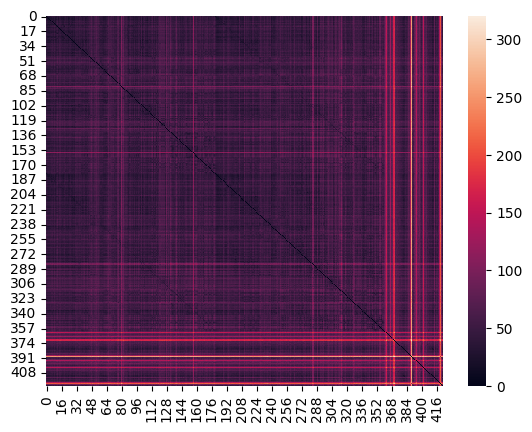

In [17]:
dtw_cl = calc_dtw(closed[0])
heatmap(dtw_cl)

### FC

In [5]:
def functional_connectivity(ts, measure="correlation"):
    """
    Functional connectivity calculation

    Parameters
    ----------
    ts: list, np.array
        List of np.arrays or np.array of shape (2, :, :) or (3, :, :)
    measure: str
        One of ["covariance", "correlation", "partial correlation", "tangent", "precision", "glasso"]. By default "correlation"

    Returns
    -------
    list of np.arrays or np.array
    """

    connectivity_measure = ConnectivityMeasure(kind=measure, standardize=False)
    fc = []
    if isinstance(ts[0], list):
        for l in ts:
            calc = connectivity_measure.fit_transform(l)
            for i in calc:
                np.fill_diagonal(i, 1)
            fc.append(calc)

    elif (isinstance(ts, np.ndarray) and len(ts.shape) == 2):
        fc = connectivity_measure.fit_transform([ts])
        for i in fc:
            np.fill_diagonal(i, 1)

        if fc.shape[0] == 1:
            fc = np.squeeze(fc)

    elif isinstance(ts, np.ndarray) and len(ts.shape) == 3:
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 1)

        if fc.shape[0] == 1:
            fc = np.squeeze(fc)

    elif isinstance(ts, list):
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 1)


    return fc

In [6]:
fc_cl = functional_connectivity(closed, 'correlation')
fc_op = functional_connectivity(opened, 'correlation')

NameError: name 'closed' is not defined

<Axes: >

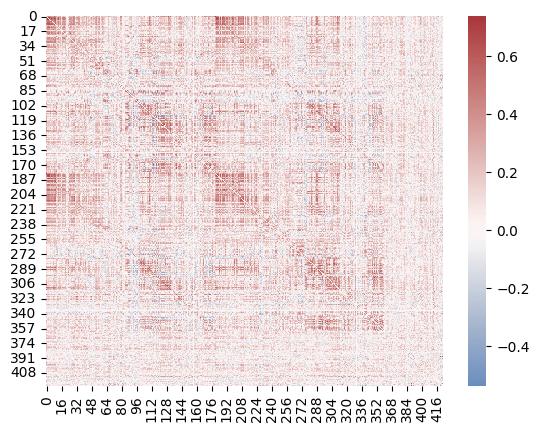

In [22]:
heatmap(fc_cl[6], center=0, cmap='vlag')

In [18]:
pc_cl = functional_connectivity(closed, 'partial correlation')
pc_op = functional_connectivity(opened, 'partial correlation')

<Axes: >

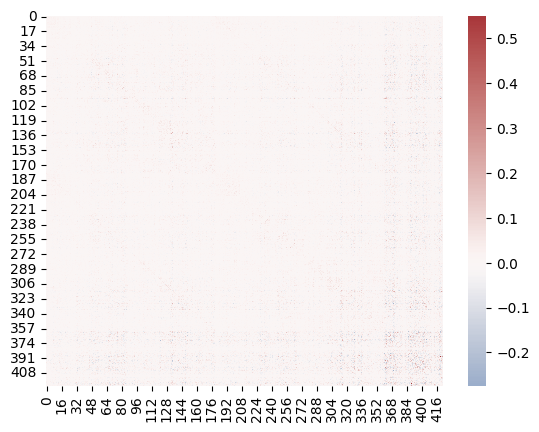

In [20]:
heatmap(pc_cl[6], center=0, cmap='vlag')

### LASSO

In [15]:
dataset = np.concatenate([fc_cl, fc_op])

In [7]:
from gglasso.problem import glasso_problem

P = glasso_problem(fc_cl, 2, 
                   reg_params={'lambda1': 0.005, 'lambda2': 0.001}, 
                   latent=False, do_scaling=False)

In [16]:
lambda1_range = np.logspace(0, -3, 5)
modelselect_params = {'lambda1_range': lambda1_range}
P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

KeyboardInterrupt: 

In [9]:
P.solve(verbose=True)

------------ADMM Algorithm for Multiple Graphical Lasso----------------
iter	       r_t	       s_t	   eps_pri	  eps_dual
   0	     5.352	      6533	  0.006357	  0.005701
   1	     2.008	      6531	  0.007663	  0.005701
   2	      2.24	      6532	   0.01028	  0.005701
   3	     2.574	      6531	    0.0155	  0.005701
   4	     2.945	      6531	   0.02595	  0.005701
   5	     3.384	      6531	   0.04685	  0.005701
   6	     3.731	      6531	   0.08865	  0.005701
   7	     4.096	      6531	    0.1723	  0.005701
   8	     4.714	      6531	    0.3395	  0.005701
   9	     5.278	      6531	    0.6739	  0.005701
  10	     5.902	      6531	     1.343	  0.005701
  11	     6.979	      6531	      2.68	  0.005701
  12	     7.993	      6531	     5.356	  0.005701
  13	     9.934	      6531	     10.71	  0.005701
  14	      10.3	      6531	     21.41	  0.005701
  15	     9.483	      6531	     42.81	  0.005701
  16	     9.098	      6531	     85.61	  0.005701
  17	     8.579	      6531	     171.2	  0.0057

/home/tm/projects/OpenCloseProject/nilearn_env/lib/python3.10/site-packages/gglasso/solver/admm_solver.py:248: UserWarning: Omega variable is not symmetric, largest deviation is 10240.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs(trp(Omega_t)- Omega_t).max()}.")


<Axes: >

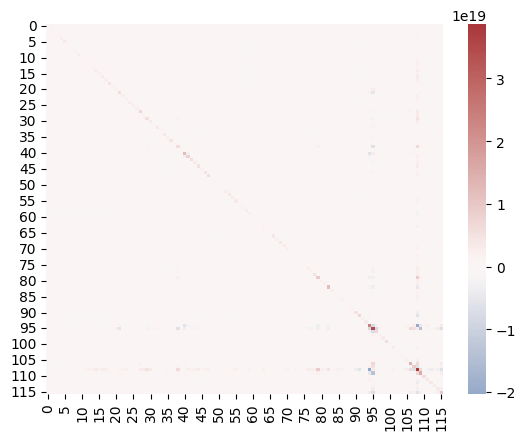

In [10]:
heatmap(P.solution.precision_[10], center=0, cmap='vlag')